# Curso Introdutório de Machine Learning - Dia 2

Nesta segunda parte, trataremos de *Deep Learning*, utilizando a biblioteca [Fast.ai](https://www.fast.ai) para criar um modelo "estado da arte" com poucas linhas de código.

Nosso objetivo novamente é desmistificar o *Deep Learning*, demonstrando como chegar em bons resultados sem grande conhecimento teórico, utilizando as ferramentas corretas.

---

## Sobre o dataset: MNIST

Nesta seção, utilizaremos o *dataset* [MNIST](https://en.wikipedia.org/wiki/MNIST_database) para treinar uma rede neural artificial capaz de reconhecer dígitos numéricos escritos à mão.

Este *dataset* é um dos *datasets* mais conhecidos para classificação (aprendizado supervisionado).

---

## Configurações

Antes de rodarmos qualquer célula, é muito importante que mudemos o processamento de CPU para GPU, assim acelerando o processo de treinamento, principalmente para *Deep Learning*.

Para isso,basta seguir as instruções:
* Clicar no menu *Runtime* na barra de ferramentas;
* Clicar em *Change runtime type*;
* Na opção *Hardware Accelerator*, mudar para *GPU*;

Este processo deve ser feito toda vez que um Notebook aberto no Google Colab.

Começamos com as configurações iniciais:
* As linhas com `autoreload` fazem com que as bibliotecas necessárias sejam carregadas automaticamente;
* A linha `matplotlib`, como mostrado anteriormente, faz com que os gráficos sejam plotados abaixo da célula;

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Vamos carregar também a biblioteca do `fast.ai`. A biblioteca já vem instalada nos ambientes virtuais do Google Colab (e do Kaggle também, caso esteja usando um *Kaggle Kernel*):

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

Excepcionalmente, por conta de uma atualização do PyTorch, a biblioteca `fast.ai` está retornando muitos UserWarnings, assim esta célula abaixo silencia tais avisos para manter o Notebook limpo:

In [0]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

Agora vamos definir o `batch_size`, que define quantas imagens por *batch* vamos processar. Isso depende bastante do tipo de processamento

In [0]:
batch_size = 64

---

## Adquirindo e visualizando os dados

Felizmente, o *dataset* *MNIST* já está indexado na biblioteca *fast.ai*, portanto basta utilizar a função `untar_data` para extrair os dados, juntamente com o atributo `MNIST` do objeto `URLs`:

In [5]:
path = untar_data(URLs.CIFAR)
path

PosixPath('/root/.fastai/data/cifar10')

Vamos usar o comando `ls` para olhar os conteúdos do `path`:

In [6]:
path.ls()

[PosixPath('/root/.fastai/data/cifar10/test'),
 PosixPath('/root/.fastai/data/cifar10/labels.txt'),
 PosixPath('/root/.fastai/data/cifar10/train')]

Podemos ver que o *dataset* já vem dividido entre teste e treinamento.

Agora vamos transformar os dados em um objeto chamado `ImageDataBunch`.

De modo similar ao `DataFrame` do `pandas`, o `ImageDataBunch` armazena todos os dados,já separando entre dados de treinamento e dados de teste - aqui chamados de validação - e recebendo parâmetros de transformação com `ds_tfms`.

Estas transformações são parte do processo de pré-processamento e *Data Augmentation*: as funções padronizam formato das imagens, realizam algumas rotações para criar variabilidade no *dataset*, realizam algumas translações, etc.

Isso tudo cria mais variabilidade entre os nosso dados, o que deixa nosso modelo mais robusto e gera mais exemplos para treinamento.

In [0]:
data = ImageDataBunch.from_folder(path, train='train', valid='test', ds_tfms=get_transforms(), bs=batch_size)

Com o método `show_batch()`, podemos ver alguns exemplos de imagens, juntamente com as suas classes:

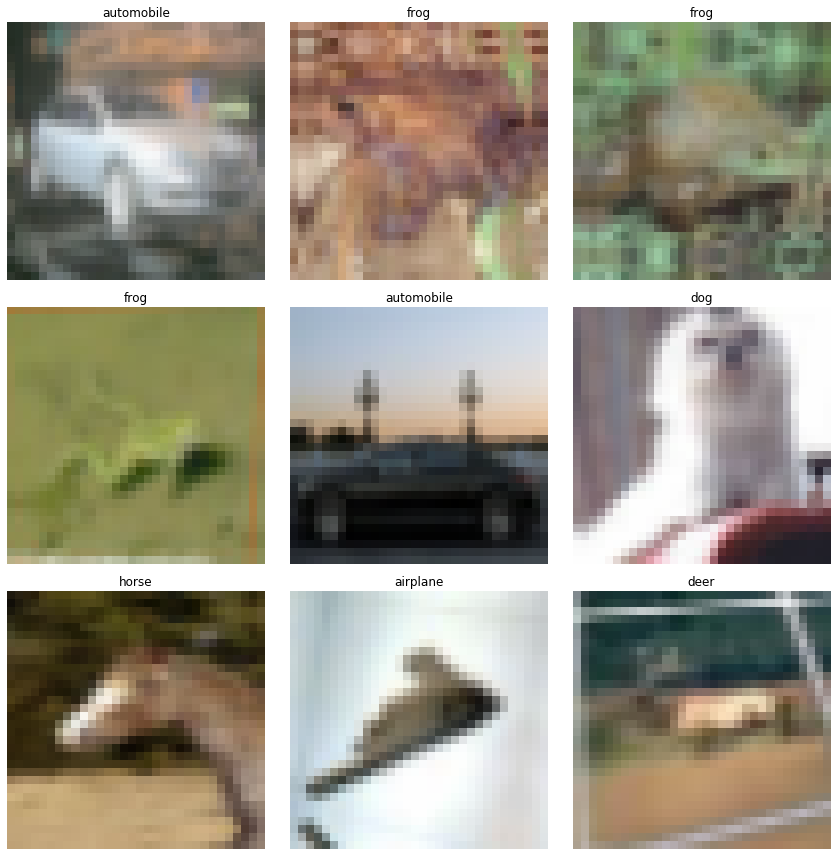

In [9]:
data.show_batch(rows=3)

Podemos ver também todas as classes possíveis com o atributo `classes` do `ImageDataBunch`:

In [10]:
print(data.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


---

## Definição do modelo e treinamento

Agora vamos definir o `learner`, ou seja, o modelo a ser usado.

Usaremos a topologia do **ResNet34**: é um tipo de arquitetura de modelo, com suas interligações específicas e algumas camadas convolucionais - não entraremos neste assunto, porém este é um artigo no [Medium](https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8) explicando a arquitetura.

Este modelo especificamente já foi pré-treinado com o dataset da [ImageNet](http://www.image-net.org/), portanto o modelo já sabe diretamente como identificar padrões comuns em imagens (como traços diagonais, linhas paralelas, etc). Isso é um exemplo de **transfer learning**, como visto na parte teórica, em que pegamos um modelo pré-treinado com suas camadas inferiores congeladas. Isso nos traz 2 vantagens principais:

* Menor tempo de treinamento;
* Menor necessidade de dados para alcançar performances do "estado da arte";

Poderíamos usar também o modelo **ResNet50**, que seria ainda melhor, porém também demoraria mais para ser treinado, portanto utilizaremos o 34.

Podemos iniciar o modelo com a classe `cnn_learner`, passando o dataset, o nome do modelo e a métrica utilizada:

In [12]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 53.2MB/s]


A título de curiosidade, podemos ver uma descrição do modelo com o atributo `model`:

In [13]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

Então, para a parte de treinamento de fato, podemos usar o método `fit_one_cycle`, passando como argumento o número de `epochs` desejados.

Neste caso, usaremos 4 epochs, o que leva um tempo bem grande para ser completo.

Além de treinar o modelo, este método aind anos fornece alguns indicadores de performance, como:
* `train_loss`: função perda para o treinamento;
* `valid_loss`: função perda para a validação;
* `error_rate`: taxa de erro no dataset de validação - métrica muito importante para ver o quão bem nosso modelo está indo;

In [14]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.589997,1.409965,0.493200,02:02
1,1.359340,1.233629,0.435500,02:00


Aqui salvamos o nosso modelo, já que em diante, iremos fazer algumas alterações nele que podem não dar certo, portanto é importante manter o progresso até aqui salvo.

In [0]:
learn.save('stage-2')

---

## Resultados

Para checar nossos resultados, vamos ver quais classes foram mais confundidas umas com as outras.

Primeiramente, veremos quais observações causaram mais dúvida no modelo. Isso é importante para vermos se o modelo está cometendo erros "honestos" ou se ainda há muito o que se melhorar.

Utilizaremos a classe `ClassificationInterpretation`, juntamente com seu método `plot_top_losses`:

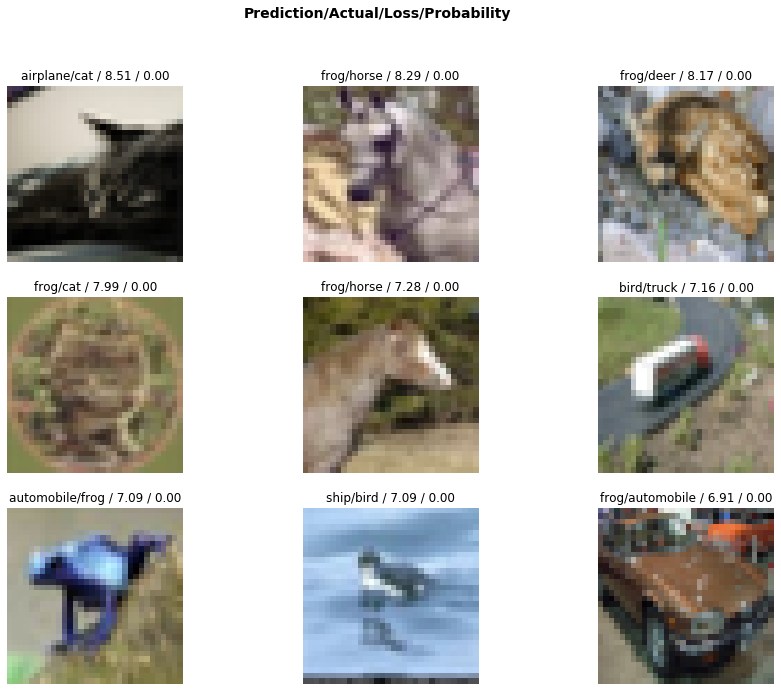

In [16]:
interp = ClassificationInterpretation.from_learner(learn)

interp.plot_top_losses(9, figsize=(15,11))

Do mesmo jeito que fizemos na primeira parte do curso, usaremos a matriz de confusão para analisar quais classes foram mais confundidas, com o `plot_confusion_matrix`:

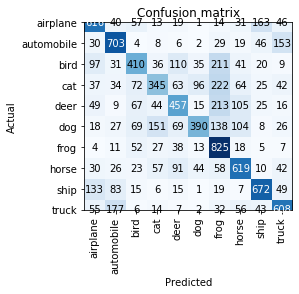

In [17]:
interp.plot_confusion_matrix()

Caso queiramos o mesmo tipo de informação, porém em forma de texto, usaremos simplesmente o `most_confused`:

In [18]:
interp.most_confused(min_val=5)

[('cat', 'frog', 222),
 ('deer', 'frog', 213),
 ('bird', 'frog', 211),
 ('truck', 'automobile', 177),
 ('airplane', 'ship', 163),
 ('automobile', 'truck', 153),
 ('dog', 'cat', 151),
 ('dog', 'frog', 138),
 ('ship', 'airplane', 133),
 ('bird', 'deer', 110),
 ('deer', 'horse', 105),
 ('dog', 'horse', 104),
 ('bird', 'airplane', 97),
 ('cat', 'dog', 96),
 ('horse', 'deer', 91),
 ('ship', 'automobile', 83),
 ('cat', 'bird', 72),
 ('dog', 'bird', 69),
 ('dog', 'deer', 69),
 ('deer', 'bird', 67),
 ('cat', 'horse', 64),
 ('cat', 'deer', 63),
 ('horse', 'frog', 58),
 ('airplane', 'bird', 57),
 ('horse', 'cat', 57),
 ('truck', 'horse', 56),
 ('truck', 'airplane', 55),
 ('frog', 'bird', 52),
 ('deer', 'airplane', 49),
 ('ship', 'truck', 49),
 ('airplane', 'truck', 46),
 ('automobile', 'ship', 46),
 ('deer', 'cat', 44),
 ('horse', 'dog', 44),
 ('truck', 'ship', 43),
 ('cat', 'truck', 42),
 ('horse', 'truck', 42),
 ('bird', 'horse', 41),
 ('airplane', 'automobile', 40),
 ('frog', 'deer', 38),
 ('

## Tunando o modelo

Conseguimos resultados muito bons para o pouco de código que utilizamos. Porém podemos melhorar este modelo ainda mais.

A técnica de **transfer learning** nos foi muito útil para o treinamento, mas agora queremos um pouco mais de liberdade para mexer nos pesos das camadas inferiores também, para adequar o modelo melhor aos dados. Portanto descongelaremos as camadas inferiores, para treiná-las também.

Mas primeiramente, vamos achar *learning rates* mais adequadas a esse ajuste fino que faremos (já que utilizar *learning rates* muito altas iria piorar a nossa performance).

Portanto, utilizaremos o `lr_find()` do nosso `learner` para calcular o gráfico de `learning_rate` contra as perdas. Isso é um exemplo de *hyperparameter tuning*, como visto na parte anterior:

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Utilizamos então o `recorder.plot()` para plotar o gráfico de fato:

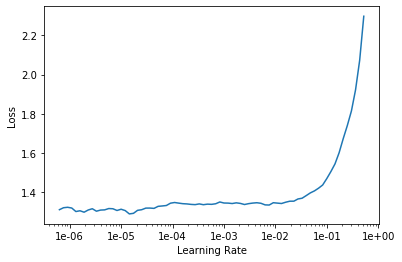

In [20]:
learn.recorder.plot()

Empiricamente, foi atestado que não devemos passar apenas um *learning rate*, mas sim um intervalo de valores, para que a *learning rate* seja ajustada dinamicamente (*learning rates* menores nas primeiras camadas e maiores nas últimas).

Para isso, vamos passar uma `slice` de valores. Também experimentalmente, foi atestado que nossa segunda parte da `slice` deve ser 10 vezes menor que o *learning rate* utilizado no estágio 1. Como o valor *default* era `1e-3`, utilizaremos `1e-4`.

Para o primeiro valor do `slice`, usaremos o gráfico acima, procurando um bom valor - via de regra, o melhor valor é o valor anterior a uma "descida" do gráfico.

Primeiramente, então descongelaremos o modelo com `unfreeze()`:

In [0]:
learn.unfreeze()

Depois utilizaremos o `fit_one_cycle()` com `max_lr` igual ao `slice` que definimos:

In [22]:
learn.fit_one_cycle(2, max_lr=slice(3e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.136928,1.003833,0.353500,02:11
1,1.019832,0.912229,0.321400,02:11


Por fim, o nosso modelo possui uma `error_rate` muito baixa, o que atesta que nosso modelo é um modelo com uma performance excelente.

Podemos realizar os mesmos passos de resultado acima, para ver como o nosso modelo melhorou.

---

## Próximos passos

Como próximos passos para melhorias, podemos citar:
* Utilizar o **ResNet50**;
* Implementar o modelo numa API usando Flask ou Django;
* Tentar treinar com mais iterações;

---

## Desafio

Implementar o mesmo *workflow* com outro *dataset*, tirado dos [URLs](https://course.fast.ai/datasets) (como o [CIFAR-10](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf)). Caso haja diferença no formato, uma consulta na documentação do `fast.ai`para `ImageDataBunch` poderá ajudar.

---


Conteúdo baseado na aula 1 do curso *Practical Deep Learning for Coders, v3*, Fast.ai, 2019.